Please refer to this assignment’s synthetic dataset. This dataset is composed of two features
belonging to observations that can be grouped into certain species. The goal is to refine the
data so that we can classify species together and use their features to classify new
observations.

1. [10 pts] Plot the data with a scatterplot. How many species must be there in the dataset?
(For the rest of this assignment, use that number as the number-of-clusters parameter in
methods such as KMeans)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Locate and load the data file
data = pd.read_csv('../../Desktop/APML/Datasets/clustering_synthetic_dataset.csv')
data.head(5)

,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937


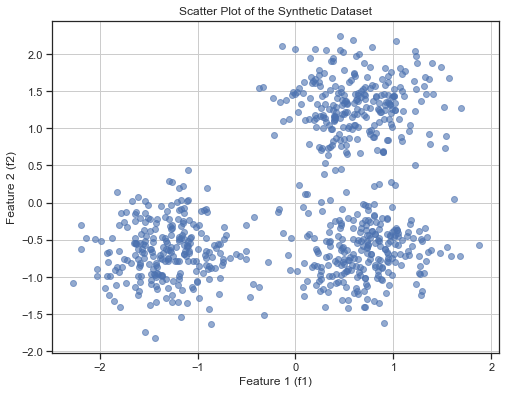

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(data['f1'], data['f2'], alpha=0.6)
plt.title('Scatter Plot of the Synthetic Dataset')
plt.xlabel('Feature 1 (f1)')
plt.ylabel('Feature 2 (f2)')
plt.grid(True)
plt.show()

Based on this visual assessment, using 3 to 4 clusters seems reasonable for further analysis.

2. [10 pts] Find the rough feature ranges to classify these species correctly. It might be a good
idea to do this step visually from some data plots. (An example statement, "Species 1 has
feature A in the range of [0-1.5]")

In the next set of problems, we will clean the points that are around the boundaries of the
cluster. (These points might be due to errors, anomalies, or simply be outliers.) This step is
done to refine feature boundaries so that a scientist can classify the species manually,
reliably, and with a high-level generalization.

1. Cluster 1: This species has f1 roughly in the range of [-2, -0.5] and f2 in the range of [-1.5, 0.5]. 

2. Cluster 2: This species' ranges are somewhat wider, with f1 roughly in the range of [0.0, 1.5] and f2 in the range of [0.5, 2.0].  Thus, Species 2 might be identified when features are within these bounds.

3. Cluster 3: This species has f1 roughly in the range of [0.0, 0.8] and f2 in the range of [-1.5, 0.0]. 

4. Cluster 4: The final cluster is characterized by f1 in the range of [0.8, 3] and f2 in the range of [-1.5, 0.0]. 

3. [20 pts] Use K-means clustering to find anomalies. (Hint: find cluster data points that are far
from the centroids.)

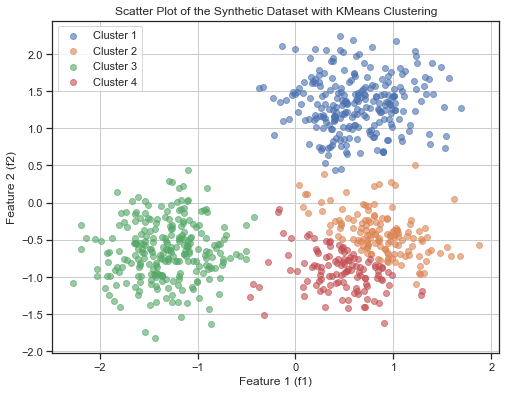

In [16]:
from sklearn.cluster import KMeans

# Assuming 4 clusters based on visual inspection of the scatter plot
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['f1', 'f2']])

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    cluster_data = data[data['cluster'] == i]
    plt.scatter(cluster_data['f1'], cluster_data['f2'], alpha=0.6, label=f'Cluster {i+1}')

plt.title('Scatter Plot of the Synthetic Dataset with KMeans Clustering')
plt.xlabel('Feature 1 (f1)')
plt.ylabel('Feature 2 (f2)')
plt.legend()
plt.grid(True)
plt.show()

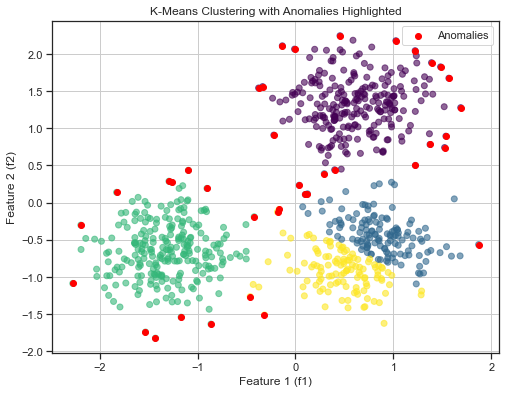

Number of anomalies through KMeans: 38


In [18]:
from scipy.spatial.distance import cdist

# Calculate dist each data point from its cluster centroid
centroids = kmeans.cluster_centers_
distances = cdist(data[['f1', 'f2']], centroids, 'euclidean')

# Get the distance to the closest centroid for each point
min_distances = distances.min(axis=1)

# Threshold for anomalies, 95% percentile
threshold = np.percentile(min_distances, 95)

anomalies = data[min_distances > threshold]

plt.figure(figsize=(8, 6))
plt.scatter(data['f1'], data['f2'], c=data['cluster'], cmap='viridis', alpha=0.6) 
plt.scatter(anomalies['f1'], anomalies['f2'], color='red', label='Anomalies')
plt.title('K-Means Clustering with Anomalies Highlighted')
plt.xlabel('Feature 1 (f1)')
plt.ylabel('Feature 2 (f2)')
plt.grid(True)
plt.legend()
plt.show()

print(f"Number of anomalies through KMeans: {len(anomalies)}") # Number of identified anomalies

4. [20 pts] Use DBSCAN clustering to find anomalies. To be clear, look for anomalies with
DBSCAN in the full dataset; this is an alternative to Q3.’s method.

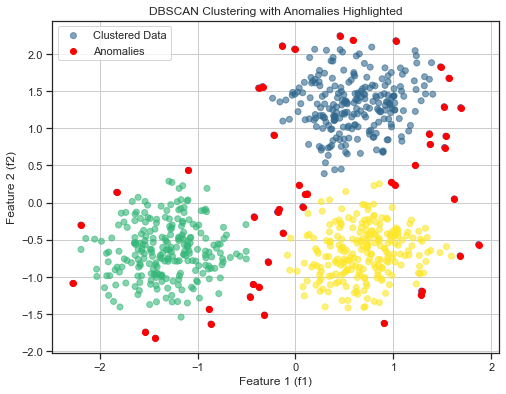

Number of anomalies through DBScan: 46


In [24]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=20)
data['dbscan_cluster'] = dbscan.fit_predict(data[['f1', 'f2']])

# Anomalies are points with a dbscan_cluster label of -1
dbscan_anomalies = data[data['dbscan_cluster'] == -1]

plt.figure(figsize=(8, 6))
plt.scatter(data['f1'], data['f2'], c=data['dbscan_cluster'], cmap='viridis', alpha=0.6, label='Clustered Data')
plt.scatter(dbscan_anomalies['f1'], dbscan_anomalies['f2'], color='red', label='Anomalies')
plt.title('DBSCAN Clustering with Anomalies Highlighted')
plt.xlabel('Feature 1 (f1)')
plt.ylabel('Feature 2 (f2)')
plt.grid(True)
plt.legend()
plt.show()

print(f"Number of anomalies through DBScan: {len(dbscan_anomalies)}")  # Number of identified anomalies

5. [30 pts] Now, choose either the K-means results from Q3. or the DBSCAN results from Q4.,
remove the points that the chosen method deemed anomalous, and train a decision tree
from the remaining data to classify the species. (You do not need to justify the choice; they
should both be reasonable options.) Visualize the model decision tree (but not just by
plotting lines on a scatterplot of the data). Hint: the result should look like Module 6’s
Jupyter Notebook’s cell [4].

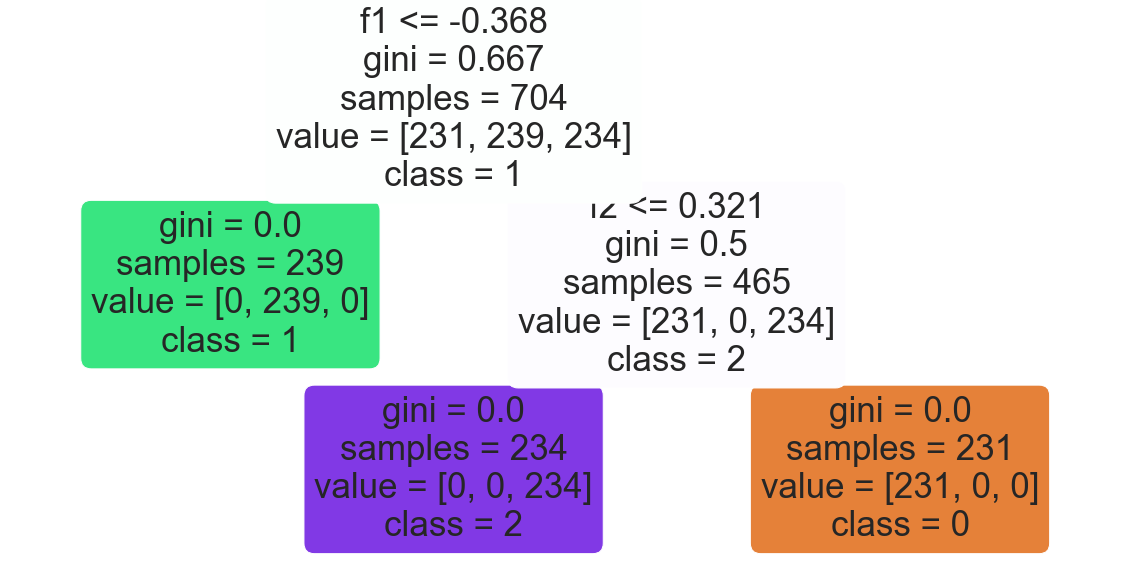

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# # Cleaned dataset without anomalies - Using KMeans
# cleaned_data =  data[min_distances <= threshold]
# cleaned_data["cluster_label"] = cleaned_data['cluster']

# Cleaned dataset without anomalies - Using DBScan
cleaned_data = data[data['dbscan_cluster'] != -1].copy()  # Exclude anomalies and create a copy
cleaned_data["cluster_label"] = cleaned_data['dbscan_cluster']

# Define features and labels for the decision tree training
X = cleaned_data[['f1', 'f2']]  # Features from the cleaned dataset
y = cleaned_data['cluster_label']  # Labels 

# Train the decision tree classifier
decision_tree_clean  = DecisionTreeClassifier(random_state=42)
decision_tree_clean.fit(X, y)

# Visualize the decision tree using the built-in plot_tree method
plt.figure(figsize=(20,10))
tree_plot = tree.plot_tree(decision_tree_clean, 
                           feature_names=X.columns,  
                           class_names=[str(i) for i in np.unique(y)],
                           filled=True,
                           rounded=True)

plt.show()


6. [10 pts] Show that, in fact, it helped to clean the outliers before generating the decision
tree. (Hint: we’re looking for something more substantial than a 100% vs. 97% accuracy
improvement.)

To demonstrate that cleaning outliers before generating the decision tree was beneficial, we can compare the performance of decision trees trained on original dataset (with outliers) and the cleaned dataset (without outliers). If outlier removal results in a simpler tree (fewer nodes and levels), this suggests that the tree is less likely to be overfitting to noise and more likely to generalize well to new data.

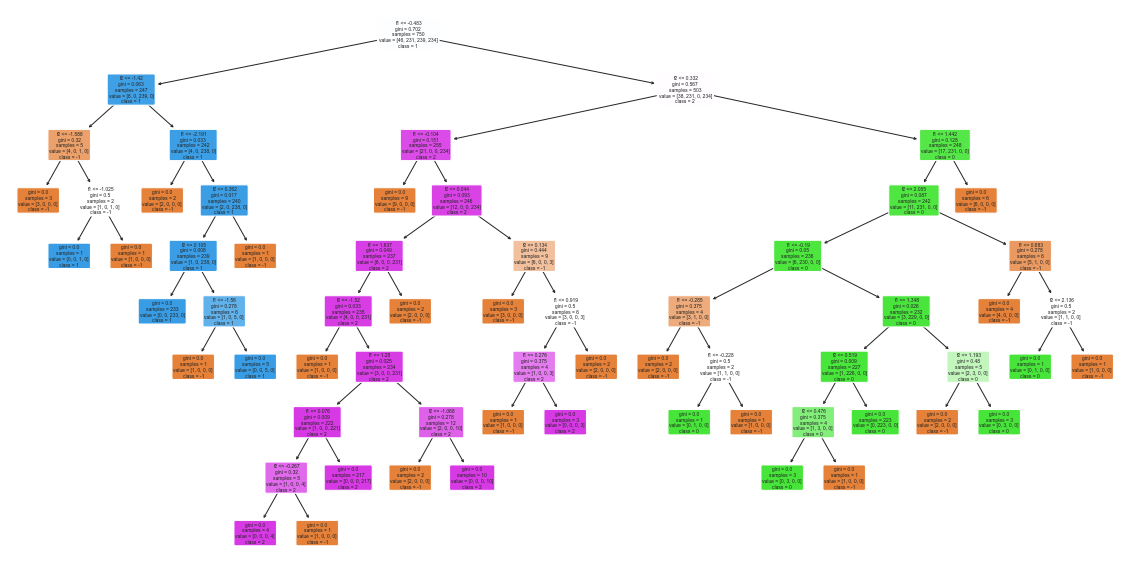

In [36]:
# Prepare the original dataset (with outliers)
X_original = data[['f1', 'f2']]  # Features from the original dataset
y_original = data['dbscan_cluster']  # Labels (including outliers)

# Train a decision tree classifier on the original dataset
decision_tree_original = DecisionTreeClassifier(random_state=42)
decision_tree_original.fit(X_original, y_original)

# Visualize the decision tree trained on the original dataset
plt.figure(figsize=(20,10))
tree_original_plot = tree.plot_tree(decision_tree_original, 
                                    feature_names=X_original.columns,  
                                    class_names=[str(i) for i in np.unique(y_original)],
                                    filled=True,
                                    rounded=True)

# Display the plot here as well
plt.show()

In [37]:
# Evaluate the two models' complexity by comparing the number of nodes and depth
original_depth = decision_tree_original.tree_.max_depth
original_nodes = decision_tree_original.tree_.node_count
cleaned_depth = decision_tree_clean.tree_.max_depth
cleaned_nodes = decision_tree_clean.tree_.node_count

(original_depth, original_nodes), (cleaned_depth, cleaned_nodes)

((9, 63), (2, 5))

Since the model complexity decreases from the outlier removal, it can be stated that model performance is likely to improve.

In [39]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores_original = cross_val_score(decision_tree_original, X_original, y_original, cv=5)
scores_cleaned = cross_val_score(decision_tree_clean, X, y, cv=5)

mean_original, std_original = np.mean(scores_original), np.std(scores_original)
mean_cleaned, std_cleaned = np.mean(scores_cleaned), np.std(scores_cleaned)

(mean_original, std_original), (mean_cleaned, std_cleaned)

((0.9600000000000002, 0.013333333333333341), (1.0, 0.0))